# HW1 - Color Quantization and Connected Component Analysis
## Alperen Gezer
### 2017405081

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


## Part 1 - Color Quantization

Firstly, we open a test image. In order to compute faster during the development phase, we reduce the sample's size.

Also, the notebook does not support cv2. In order to display images we need to use matplotlib libarary and convert BGR space of cv2 to RGB.

(Converted it to LAB for processing)

In [2]:
image = cv2.imread('cq1.jpeg')
image = cv2.resize(image, (image.shape[1]//4, image.shape[0]//4))
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

Then we define our K-Means clustering algorithm.

In [3]:
class custom_kmeans:
    def __init__(self, K, dims, range=(0,1)):
        self._centers_ = np.random.random((K, dims), )* (range[1]-range[0]) +range[0]
        self._centers_ = self._centers_.astype(int)
        self.labels_ = []

    def fit(self, data):
        i = 1
        while True:
            labeled_data = self.find_nearest(data)
            isChanged = False
            for K in range(self._centers_.shape[0]):
                cluster = labeled_data[:,-1]
                cluster = np.where(cluster == K)
                if cluster[0].shape[0]<1:
                    self._centers_[K] = data[np.random.randint(0, data.shape[0])]
                    continue
                cluster = labeled_data[cluster]
                new_point = cluster[:,:-1].mean(axis=0).astype(int)
                if not np.allclose(self._centers_[K],new_point):
                    self._centers_[K] = new_point
                    isChanged = True
            i += 1
            if not isChanged:
                break
        self.labels_ = labeled_data[:,-1]
        return self

    def find_nearest(self, data):
        labeled_data = np.empty((0,data.shape[1]+1), dtype=int)
        inertia = 0
        for i in range(data.shape[0]):
            distances = [np.square(data[i]-self._centers_[K]).sum() for K in range(self._centers_.shape[0])]
            inertia += np.min(distances)/(65025*len(data))
            labeled_row = np.hstack((data[i], [np.argmin(distances)]))
            labeled_data = np.vstack((labeled_data, labeled_row))
        self.inertia = inertia
        return labeled_data

Following defining the custom k-means algorithm, we will check if it works as it is expected. For comparison we will also use SKLearn's implementation of k-means.

In [4]:
from sklearn.cluster import KMeans

K=4
custom_cluster = custom_kmeans(K, 3, (0,255)).fit(image.reshape(-1,3))
sklearn_cluster = KMeans(n_clusters=K).fit(image.reshape(-1,3))

After the clustering, we need to visualize the results.

In [5]:
def convert_to_image(shape, clusters, centers):
    colors = centers[clusters]
    img = np.reshape(colors, shape)
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_LAB2RGB)

Text(0.5, 1.0, "SKLearn's Implementation")

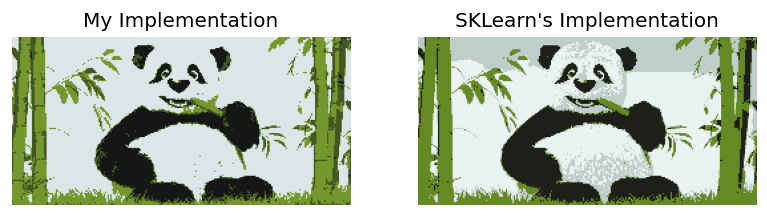

In [6]:
custom_quantized_image = convert_to_image(image.shape, custom_cluster.labels_, custom_cluster._centers_)
sklearn_quantized_image = convert_to_image(image.shape, sklearn_cluster.labels_, sklearn_cluster.cluster_centers_.astype(np.uint8))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), dpi=120)
ax1.imshow(custom_quantized_image)
ax1.axis('off')
ax1.set_title('My Implementation')
ax2.imshow(sklearn_quantized_image)
ax2.axis('off')
ax2.set_title('SKLearn\'s Implementation')


Next we will create our catalog with the desired settings. For catalog to be perfect rectangle we set all resolutions to 300x600.

In [9]:
results = np.empty((0,600*5,3), dtype=np.uint8)
for file in ['cq1.jpeg', 'cq2.jpeg', 'cq3.jpeg']:
    image = cv2.imread(file)
    image = cv2.resize(image, (600, 300))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    row = np.empty((300,0,3), dtype=np.uint8)
    for K in [2, 4, 8, 16, 32]:
        custom_cluster = custom_kmeans(K, 3, (0,255)).fit(image.reshape(-1,3))
        custom_quantized_image = convert_to_image(image.shape, custom_cluster.labels_, custom_cluster._centers_)
        row = np.hstack((row, custom_quantized_image))

        # sklearn_cluster = KMeans(n_clusters=K).fit(image.reshape(-1,3))
        # sklearn_quantized_image = convert_to_image(image.shape, sklearn_cluster.labels_, sklearn_cluster.cluster_centers_.astype(np.uint8))
        # row = np.hstack((row, sklearn_quantized_image))

    results = np.vstack((results, row))


KeyboardInterrupt: 

(-0.5, 2999.5, 899.5, -0.5)

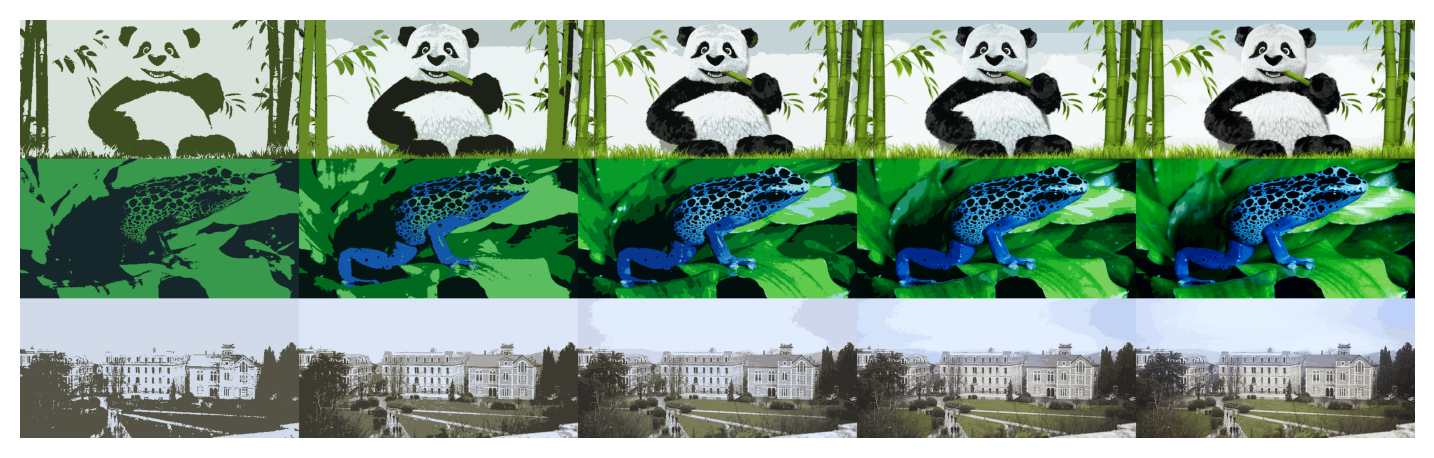

In [8]:
plt.figure(figsize=(9,30), dpi=200)
plt.imshow(results)
plt.axis('off')